# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Initialize the LabelEncoder and MinMaxScaler to use later.
le = preprocessing.LabelEncoder()
mms = MinMaxScaler()

**Exploring portfolio dataframe**

First we will be exploring portfolio dataframe.

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


**Cleaning portfolio dataframe**

Here we will be cleaning portfolio dataframe.

In [4]:
# Split channels column in 4 different columns and set 1 in a row if that channel is present otherwise set 0.
channel_columns = ["web", "email", "mobile", "social"]
def check_channel(channels):
    """ 
    Checks for channel if it is present in the list of channels passed. 
  
    Parameters: 
    channels (list of string): list containing names of channels
  
    Returns: 
    int: (int) return 1 if channels contain the channel otherwise 0.
  
    """
    return 1 if channel in channels else 0
    
for channel in channel_columns:
    portfolio[channel] = portfolio["channels"].apply(check_channel)

In [5]:
# Drop the channels column
portfolio.drop(["channels"], axis = 1, inplace=True)

In [6]:
# Transform the offer_type column by LabelEncoder.
portfolio["offer_type"] = le.fit_transform(portfolio["offer_type"])

In [7]:
# Transform the offer_type column by LabelEncoder.
portfolio["offer_id_index"] = le.fit_transform(portfolio["id"])

In [8]:
# Using MinMaxScaler scale the values for the "difficulty", "duration" and "reward" column
portfolio[["difficulty", "duration", "reward"]] = mms.fit_transform(portfolio[["difficulty", "duration", "reward"]])

In [9]:
portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social,offer_id_index
0,0.50,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,0,1.0,0,1,1,1,7
1,0.50,0.285714,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1.0,1,1,1,1,4
2,0.00,0.142857,3f207df678b143eea3cee63160fa8bed,2,0.0,1,1,1,0,3
3,0.25,0.571429,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.5,1,1,1,0,6
4,1.00,1.000000,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0.5,1,1,0,0,0
5,0.35,0.571429,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0.3,1,1,1,1,1
6,0.50,1.000000,fafdcd668e3743c1bb461111dcafc2a4,1,0.2,1,1,1,1,9
7,0.00,0.000000,5a8bc65990b245e5a138643cd4eb9837,2,0.0,0,1,1,1,5
8,0.25,0.285714,f19421c1d4aa40978ebb69ca19b0e20d,0,0.5,1,1,1,1,8
9,0.50,0.571429,2906b810c7d4411798c6938adc9daaa5,1,0.2,1,1,1,0,2


**Exploring profile dataframe**

Here we will be exploring profile dataframe.

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.shape

(17000, 5)

**Cleaning profile dataframe**

Here we will be cleaning profile dataframe.

In [12]:
# Fill "NaN" string in gender column 
profile.gender.fillna('NaN', inplace=True)

In [13]:
# Use LabelEncoder to encode gender column
profile["gender"] = le.fit_transform(profile["gender"])

In [14]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,2,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,0,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,2,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,2,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
profile.describe()

,age,became_member_on,gender,income
count,17000.000000,1.700000e+04,17000.000000,14825.000000
mean,62.531412,2.016703e+07,0.792353,65404.991568
std,26.738580,1.167750e+04,0.703751,21598.299410
min,18.000000,2.013073e+07,0.000000,30000.000000
25%,45.000000,2.016053e+07,0.000000,49000.000000
50%,58.000000,2.017080e+07,1.000000,64000.000000
75%,73.000000,2.017123e+07,1.000000,80000.000000
max,118.000000,2.018073e+07,3.000000,120000.000000


In [16]:
profile.gender.value_counts()

1    8484
0    6129
2    2175
3     212
Name: gender, dtype: int64

In [17]:
# It looks like for the nan income and nan gender, the age is 118, which might be a data error. 
# So we can put nan where age is 118
profile[profile.gender.isnull()][profile.age == 118][profile.income.isnull()].sort_values("age").shape

# Replace 118 with np.nan in age column
profile["age"] = profile["age"].apply(lambda age: np.nan if age == 118 else age)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
profile.isnull().sum()

age                 2175
became_member_on       0
gender                 0
id                     0
income              2175
dtype: int64

In [19]:
# Get rid of the entries which have age as np.nan. Since they will also be having gender and income as np.nan.
profile = profile[profile.age.notnull()]

In [20]:
# Segment age data in four bins
profile["age"] = pd.cut(profile.age, bins=4, labels=False)

In [21]:
# Calculate the number of days since the user has created the account on the app and delete became_member_on column.
profile["became_member_on"] = [str(value) for value in profile["became_member_on"]]
profile["member_since_days"] = profile.became_member_on.apply(lambda s: (datetime.datetime.utcnow() - datetime.datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))).days)
profile.drop(["became_member_on"], axis = 1, inplace=True)


In [22]:
# Segment member_since_days data in four bins
profile["member_since_days"] = pd.cut(profile.member_since_days, bins=3, labels=False)

In [23]:
# Segment income data in three bins
profile["income"] = pd.cut(profile.income, bins=3, labels=False)

In [24]:
profile.head()

,age,gender,id,income,member_since_days
1,1,0,0610b486422d4921ae7d2bf64640c50b,2,0
3,2,0,78afa995795e4d85b5d9ceeca43f5fef,2,0
5,2,1,e2127556f4f64592b11af22de27a7932,1,0
8,2,1,389bc3fa690240e798340f5a15918d5c,0,0
12,1,1,2eeac8d8feae4a8cad5a6af0499a211d,0,0


In [25]:
profile.describe()

,age,gender,income,member_since_days
count,14825.00000,14825.000000,14825.000000,14825.000000
mean,1.26597,0.615177,0.696526,0.431096
std,0.84968,0.567941,0.712319,0.628726
min,0.00000,0.000000,0.000000,0.000000
25%,1.00000,0.000000,0.000000,0.000000
50%,1.00000,1.000000,1.000000,0.000000
75%,2.00000,1.000000,1.000000,1.000000
max,3.00000,3.000000,2.000000,2.000000


**Exploring transcript dataframe**

Here we will be exploring transcript dataframe.

In [26]:
transcript.shape

(306534, 4)

In [27]:
transcript[transcript.event.isin(["offer viewed",])].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [28]:
transcript[transcript.event.isin(["offer received"])].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:
transcript[transcript.event.isin(["transaction"])].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [30]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [31]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [32]:
transcript.person.nunique()

17000

**Cleaning transcript dataframe**

Here we will be cleaning transcript dataframe.

In [33]:
# Create an amount column for the purchases done.
transcript["amount"] = transcript["value"].apply(lambda x: x.get('amount'))

In [34]:
# Create a offer_id column for events of offers
transcript["offer_id"] = transcript["value"].apply(lambda x: x.get('offer_id') if x.get("offer_id") is not None else x.get("offer id"))
transcript.drop(["value"], axis = 1, inplace=True)
                                                 

In [35]:
transcript.head()

,event,person,time,amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [36]:
# Since the amount data is not needed for further processes, so dropping it.
transcript.drop(["amount"], axis = 1, inplace=True)

# Also delete the rows where offer_id is null. It will be for the cases, where amount was having some value.
transcript = transcript[transcript.offer_id.notnull()]

In [37]:
transcript.isnull().sum()

event       0
person      0
time        0
offer_id    0
dtype: int64

In [38]:
transcript.head()

,event,person,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [39]:
transcript.shape

(167581, 4)

In [40]:
# Sort the data by person and offer_id and then group by person and offer id
grouped_values = transcript.sort_values(["person", "offer_id"]).groupby(["person", "offer_id"])


In [41]:
grouped_values.head()

,event,person,time,offer_id
247879,offer received,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5
258884,offer completed,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4


So The events should in the sequence of 1. offer received 2. offer viewed 3. offer completed to make user be influenced by the offer.

For that the following condition should satisfy:
1. When combining the event column for a particular person and offer_id, it should contain "offer receivedoffer viewedoffer completed", then the offer has influnced that person.

So to get that data, filter has to applied where the conditions is present.

Since the same offer is sent to a user multiple times and he can complete or not after viewing it.
Here I am assuming the person is influenced by the offer if he has completed anyone of the sent offers after viewing it.


In [42]:
# Combine the event column for similar person and offer_id, and then check whether the combined values has "offer receivedoffer viewedoffer completed" in it, 
# This way, we will know that the offer influenced the user.
event_combined_df = grouped_values['event'].apply(lambda x: ''.join(x)).reset_index()
coupon_used_data = event_combined_df[event_combined_df["event"].str.find("offer receivedoffer viewedoffer completed") > -1]

# Add one more column for coupon_used which will have true for the current data.
coupon_used_data["coupon_used"] = True
coupon_used_data.drop(["event"], axis = 1, inplace=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
coupon_used_data.head()

,person,offer_id,coupon_used
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,True
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,True
10,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,True
11,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,True
14,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,True


In [44]:
transcript.rename(columns={"person": "person_id"}, inplace=True)
transcript.head()

,event,person_id,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [45]:
transcript.shape

(167581, 4)

In [46]:
profile.rename(columns={"id": "person_id"}, inplace=True)
profile.head()

,age,gender,person_id,income,member_since_days
1,1,0,0610b486422d4921ae7d2bf64640c50b,2,0
3,2,0,78afa995795e4d85b5d9ceeca43f5fef,2,0
5,2,1,e2127556f4f64592b11af22de27a7932,1,0
8,2,1,389bc3fa690240e798340f5a15918d5c,0,0
12,1,1,2eeac8d8feae4a8cad5a6af0499a211d,0,0


In [47]:
# Merge transcript dataframe with profile dataframe
transcript = transcript.merge(profile, on=["person_id"])
transcript.shape

(148805, 8)

In [48]:
transcript.head()

,event,person_id,time,offer_id,age,gender,income,member_since_days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,2,0,2,0
4,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,2,0,2,0


In [49]:
portfolio.rename(columns={"id": "offer_id"}, inplace=True)
portfolio.head() 

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social,offer_id_index
0,0.50,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,0,1.0,0,1,1,1,7
1,0.50,0.285714,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1.0,1,1,1,1,4
2,0.00,0.142857,3f207df678b143eea3cee63160fa8bed,2,0.0,1,1,1,0,3
3,0.25,0.571429,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.5,1,1,1,0,6
4,1.00,1.000000,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0.5,1,1,0,0,0


In [50]:
# Merge transcript data frame with portfolio dataframe
transcript = transcript.merge(portfolio, on= ["offer_id"])
transcript.shape

(148805, 17)

In [51]:
transcript.head()

,event,person_id,time,offer_id,age,gender,income,member_since_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_id_index
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6


In [52]:
transcript.isnull().sum()

event                0
person_id            0
time                 0
offer_id             0
age                  0
gender               0
income               0
member_since_days    0
difficulty           0
duration             0
offer_type           0
reward               0
web                  0
email                0
mobile               0
social               0
offer_id_index       0
dtype: int64

In [53]:
transcript.head()

,event,person_id,time,offer_id,age,gender,income,member_since_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_id_index
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6


In [54]:
coupon_used_data.rename(columns={"person": "person_id"}, inplace=True)
coupon_used_data.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,person_id,offer_id,coupon_used
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,True
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,True
10,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,True
11,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,True
14,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,True


In [55]:
coupon_used_data.shape

(20926, 3)

In [56]:
# Perform a left join on transcript and coupon_used_data
transcript = transcript.merge(coupon_used_data, how="left", on=["person_id", "offer_id"])

In [57]:
transcript.isnull().sum()

event                    0
person_id                0
time                     0
offer_id                 0
age                      0
gender                   0
income                   0
member_since_days        0
difficulty               0
duration                 0
offer_type               0
reward                   0
web                      0
email                    0
mobile                   0
social                   0
offer_id_index           0
coupon_used          75215
dtype: int64

In [58]:
# Fill False for the nan values in coupon_used column
transcript[["coupon_used"]] = transcript[["coupon_used"]].fillna(value=False)

In [59]:
transcript.isnull().sum()

event                0
person_id            0
time                 0
offer_id             0
age                  0
gender               0
income               0
member_since_days    0
difficulty           0
duration             0
offer_type           0
reward               0
web                  0
email                0
mobile               0
social               0
offer_id_index       0
coupon_used          0
dtype: int64

In [60]:
transcript.head()

,event,person_id,time,offer_id,age,gender,income,member_since_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_id_index,coupon_used
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,True


In [61]:
transcript.coupon_used.value_counts()

False    75215
True     73590
Name: coupon_used, dtype: int64

In [62]:
transcript.head()

,event,person_id,time,offer_id,age,gender,income,member_since_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_id_index,coupon_used
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,True


In [63]:
transcript.shape

(148805, 18)

In [64]:
# We can remove the time and event, since we have captured their result in coupon_used column
transcript.drop(["event", "time"], axis = 1, inplace=True)

In [65]:
# Check for duplicated data.
transcript[transcript.duplicated()].shape

(93583, 16)

In [66]:
# Delete the duplicated data.
transcript = transcript[~transcript.duplicated()] 

In [67]:
transcript.shape

(55222, 16)

In [68]:
transcript.head()

,person_id,offer_id,age,gender,income,member_since_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_id_index,coupon_used
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
3,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
6,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,0,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
11,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,False
15,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,2,0.25,0.571429,0,0.5,1,1,1,0,6,False


In [69]:
transcript.isnull().sum()

person_id            0
offer_id             0
age                  0
gender               0
income               0
member_since_days    0
difficulty           0
duration             0
offer_type           0
reward               0
web                  0
email                0
mobile               0
social               0
offer_id_index       0
coupon_used          0
dtype: int64

In [70]:
transcript.person_id.nunique()

14820

In [71]:
transcript.head(20)

,person_id,offer_id,age,gender,income,member_since_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_id_index,coupon_used
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
3,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
6,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,1,0,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
11,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,False
15,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,2,0.25,0.571429,0,0.5,1,1,1,0,6,False
18,868317b9be554cb18e50bc68484749a2,9b98b8c7a33c4b65b9aebfe6a799e6d9,3,0,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,False
20,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,0.25,0.571429,0,0.5,1,1,1,0,6,False
25,102e9454054946fda62242d2e176fdce,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,0,1,0.25,0.571429,0,0.5,1,1,1,0,6,True
31,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0,0.25,0.571429,0,0.5,1,1,1,0,6,True
34,57dd18ec5ddc46828afb81ec5977bef2,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,0,0.25,0.571429,0,0.5,1,1,1,0,6,False


In [72]:
transcript.shape

(55222, 16)

**Data Visualization**

*Countplot for income and coupon_used*


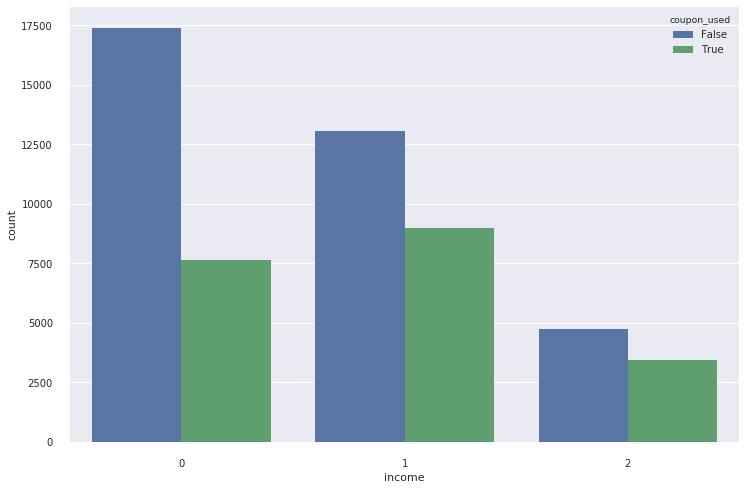

In [73]:
# set the background colour of the plot to white
sns.set(style="whitegrid", color_codes=True)

# setting the plot size for all plots
sns.set(rc={'figure.figsize':(12,8)})

# create a countplot for income and coupon_used
sns.countplot('income',data=transcript,hue = 'coupon_used')

# Remove the top and down margin
sns.despine(offset=10, trim=True)

# display the plotplt.show()
# Income group in 3 bins in 30k and 120k income range

*Countplot for age and coupon_used*

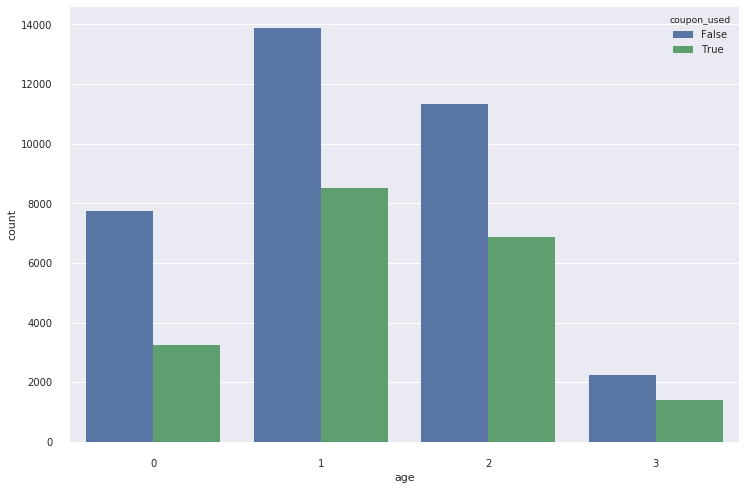

In [74]:
# create a countplot for age and coupon_used
sns.countplot('age',data=transcript,hue = 'coupon_used')

# Remove the top and down margin
sns.despine(offset=10, trim=True)

# display the plotplt.show()
# age groups in 4 bins in 18 and 101 age range

*Countplot for gender and coupon_used*

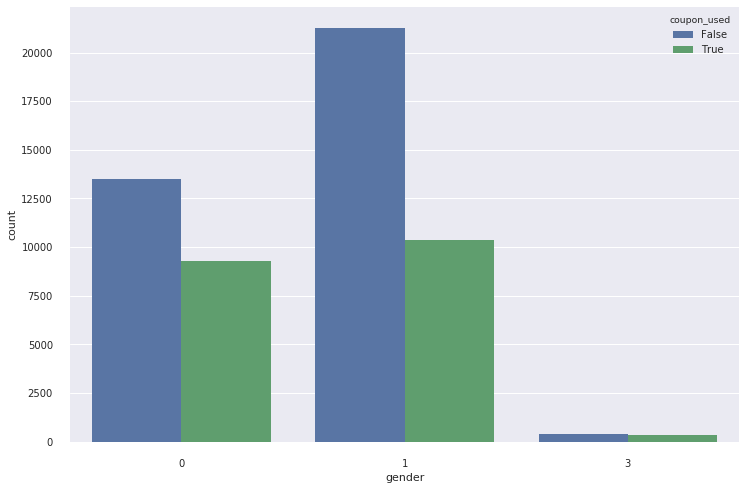

In [75]:
# create a countplot for gender and coupon_used
sns.countplot('gender',data=transcript,hue = 'coupon_used')

# Remove the top and down margin
sns.despine(offset=10, trim=True)

# display the plotplt.show()
# 0 -> F , 1 -> M , 2 -> O

*Countplot for offer_type and coupon_used*

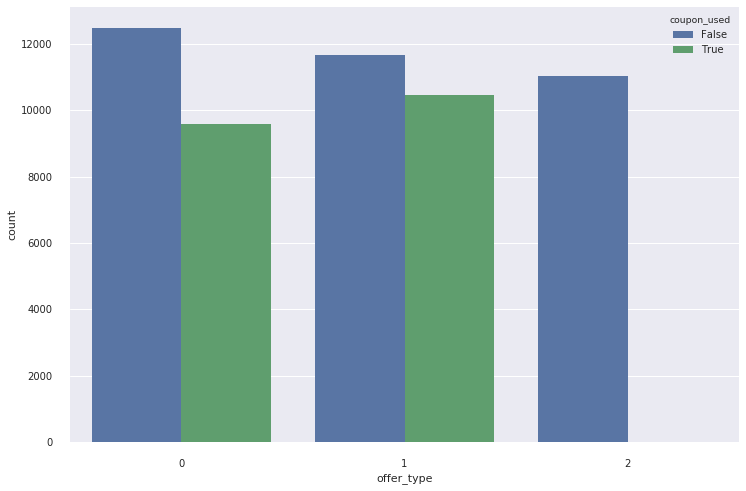

In [76]:
# create a countplot for gender and coupon_used
sns.countplot('offer_type',data=transcript,hue = 'coupon_used')

# Remove the top and down margin
sns.despine(offset=10, trim=True)

# display the plotplt.show()
# 0 -> BOGO , 1 -> Discount , 2 -> Informational

**Split the data in training and test sets and then predict on test data using different algorithms**

In [77]:
# Get feature columns from transcript dataframe
X = transcript.drop(["person_id", "offer_id", "coupon_used"], axis = 1) 

In [78]:
# Get target variable column from transcript dataframe
y = transcript["coupon_used"] 

In [79]:
X.head()

,age,gender,income,member_since_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_id_index
0,2,0,2,0,0.25,0.571429,0,0.5,1,1,1,0,6
3,2,1,1,0,0.25,0.571429,0,0.5,1,1,1,0,6
6,2,1,0,0,0.25,0.571429,0,0.5,1,1,1,0,6
11,1,0,1,0,0.25,0.571429,0,0.5,1,1,1,0,6
15,1,1,0,2,0.25,0.571429,0,0.5,1,1,1,0,6


In [80]:
X.isnull().sum()

age                  0
gender               0
income               0
member_since_days    0
difficulty           0
duration             0
offer_type           0
reward               0
web                  0
email                0
mobile               0
social               0
offer_id_index       0
dtype: int64

In [81]:
# Split the data in Training Set & Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Naive-Bayes


In [82]:
X_train.shape, y_train.shape

((44177, 13), (44177,))

In [94]:
# Create a dictionary to store predictions done by different algorithms
all_preds = dict()

In [95]:
# Create an object of the type GaussianNB
gnb = GaussianNB()

# Train the algorithm on training data and predict using the testing data
pred = gnb.fit(X_train, y_train).predict(X_test)
all_preds["Naive-Bayes"] = pred

print("Naive-Bayes accuracy : ",accuracy_score(y_test, pred, normalize = True))

Naive-Bayes accuracy :  0.658035310095


In [99]:
# Create an object of type LinearSVC
svc_model = LinearSVC(random_state=0)

# Train the algorithm on training data and predict using the testing data
pred = svc_model.fit(X_train, y_train).predict(X_test)
all_preds["LinearSVC"] = pred

# Print the accuracy score of the model
print("LinearSVC accuracy : ",accuracy_score(y_test, pred, normalize = True))

LinearSVC accuracy :  0.724400181077


In [97]:
# Create object of the lassifier
neigh = KNeighborsClassifier(n_neighbors=5)

# Train the algorithm
neigh.fit(X_train, y_train)

# Predict the response
pred = neigh.predict(X_test)
all_preds["KNeighbors"] = pred

# Evaluate accuracy
print ("KNeighbors accuracy score : ",accuracy_score(y_test, pred))

KNeighbors accuracy score :  0.712630149389


**Classification reports for all the alogorithms**

Now we can check classification reports for the alogrithms used.

In [98]:
for key, pred in all_preds.items():
    print("Classification report for {} algorithm:".format(key))
    print(classification_report(y_test, pred))


Classification report for Naive-Bayes algorithm:
             precision    recall  f1-score   support

      False       0.88      0.54      0.67      7088
       True       0.51      0.87      0.65      3957

avg / total       0.75      0.66      0.66     11045

Classification report for LinearSVC algorithm:
             precision    recall  f1-score   support

      False       0.77      0.81      0.79      7088
       True       0.62      0.58      0.60      3957

avg / total       0.72      0.72      0.72     11045

Classification report for KNeighbors algorithm:
             precision    recall  f1-score   support

      False       0.78      0.77      0.78      7088
       True       0.60      0.61      0.60      3957

avg / total       0.71      0.71      0.71     11045

